# Obstacles Detection for visually impaired Using Fine-Tuning (Mobile-Net)

In [3]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn as sns
import kagglehub
import numpy as np
import random
import torch

## DataSet Download & Preprocess

In [ ]:

# Download the dataset
path = kagglehub.dataset_download("idrisskh/obstacles-dataset")
full_path = path + '/obstacles dataset'

print("Path to dataset files:", full_path)

Path to dataset files: /home/hamza_ok/.cache/kagglehub/datasets/idrisskh/obstacles-dataset/versions/1/obstacles dataset


In [5]:
# Define the transforms
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = datasets.ImageFolder(root=full_path + '/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root=full_path + '/test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [3]:
# Load pre-trained MobileNetV2
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layers except the classifier
for param in mobilenet.features.parameters():
    param.requires_grad = False

# Modify the classifier to match the number of classes
num_classes = len(train_dataset.classes)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, num_classes)

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet = mobilenet.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 134MB/s]


In [4]:
# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.classifier.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    mobilenet.train()
    train_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct / len(train_loader.dataset)
    
    # Validation
    mobilenet.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mobilenet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / len(val_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}: ")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print('-'*40)

Epoch 1/10: 
Train Loss: 1.1472, Train Accuracy: 0.6440
Val Loss: 0.7069, Val Accuracy: 0.8194
----------------------------------------
Epoch 2/10: 
Train Loss: 0.6783, Train Accuracy: 0.7858
Val Loss: 0.5959, Val Accuracy: 0.8333
----------------------------------------
Epoch 3/10: 
Train Loss: 0.6039, Train Accuracy: 0.8056
Val Loss: 0.4795, Val Accuracy: 0.8449
----------------------------------------
Epoch 4/10: 
Train Loss: 0.5325, Train Accuracy: 0.8282
Val Loss: 0.3775, Val Accuracy: 0.8981
----------------------------------------
Epoch 5/10: 
Train Loss: 0.5175, Train Accuracy: 0.8257
Val Loss: 0.4309, Val Accuracy: 0.8472
----------------------------------------
Epoch 6/10: 
Train Loss: 0.4745, Train Accuracy: 0.8458
Val Loss: 0.4189, Val Accuracy: 0.8796
----------------------------------------
Epoch 7/10: 
Train Loss: 0.4723, Train Accuracy: 0.8391
Val Loss: 0.4910, Val Accuracy: 0.8403
----------------------------------------
Epoch 8/10: 
Train Loss: 0.4496, Train Accuracy:

In [5]:
# mobilenet = best_model

----------------------------------------
---- Final Result ----
Val Loss: 0.4095, Val Accuracy: 0.8704
Classification Report (Validation):
               precision    recall  f1-score   support

       chair       0.84      0.67      0.74        24
        door       0.95      0.71      0.81        51
       fence       0.80      0.67      0.73        12
 garbage_bin       0.93      0.76      0.84        17
    obstacle       1.00      0.91      0.95        91
       plant       0.89      1.00      0.94        24
     pothole       0.82      0.90      0.86        30
      stairs       0.71      0.97      0.82        60
       table       0.73      0.91      0.81        33
     vehicle       0.95      0.90      0.93        90

    accuracy                           0.87       432
   macro avg       0.86      0.84      0.84       432
weighted avg       0.89      0.87      0.87       432



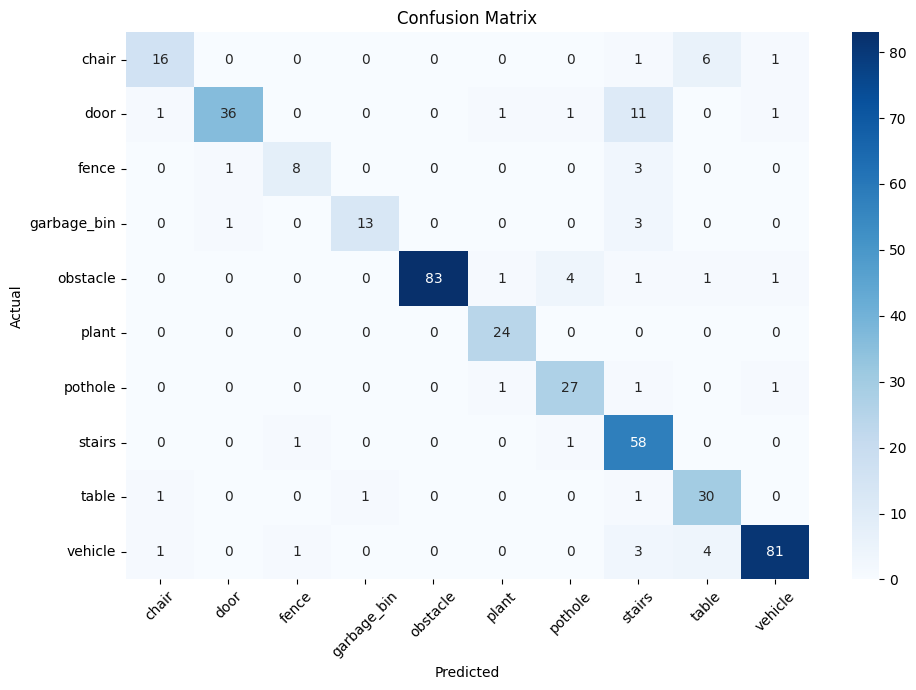

In [6]:
# Validation
mobilenet.eval()
val_loss, correct = 0.0, 0
all_labels, all_preds = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
            
        val_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

val_loss /= len(val_loader.dataset)
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
conf_matrix = confusion_matrix(all_labels, all_preds)

print('-'*40)
print('---- Final Result ----')
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}")
print("Classification Report (Validation):\n", report)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [7]:
def visualize_predictions(model, dataset, num_classes=5, device='cpu'):

    # Map class indices to names
    class_to_idx = dataset.class_to_idx  # Class to index mapping
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping
    print('idx_to_class : ', idx_to_class)
    
    # Randomly sample one image per class
    sampled_images = {}
    for class_label in random.sample(list(class_to_idx.values()), num_classes):
        for i in range(len(dataset)):
            img, label = dataset[i]
            if label == class_label:
                sampled_images[class_label] = (img, label)
                break  # Stop after finding one example for the class
    
    # Prepare for predictions
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
        for ax, (class_label, (img, label)) in zip(axes, sampled_images.items()):
            # Prepare image for model
            input_img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
            output = model(input_img)
            pred_label = output.argmax(dim=1).item()  # Get the predicted class index
            
            # Prepare the image for visualization
            img = img.numpy().transpose((1, 2, 0))  # Convert tensor to HxWxC format
            img = np.clip(
                img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]),
                0, 1
            )
            
            # Display the image
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(
                f"True: {idx_to_class[label]}\nPred: {idx_to_class[pred_label]}",
                fontsize=10,
                color="green" if label == pred_label else "red"
            )
    
    plt.tight_layout()
    plt.show()

idx_to_class :  {0: 'chair', 1: 'door', 2: 'fence', 3: 'garbage_bin', 4: 'obstacle', 5: 'plant', 6: 'pothole', 7: 'stairs', 8: 'table', 9: 'vehicle'}


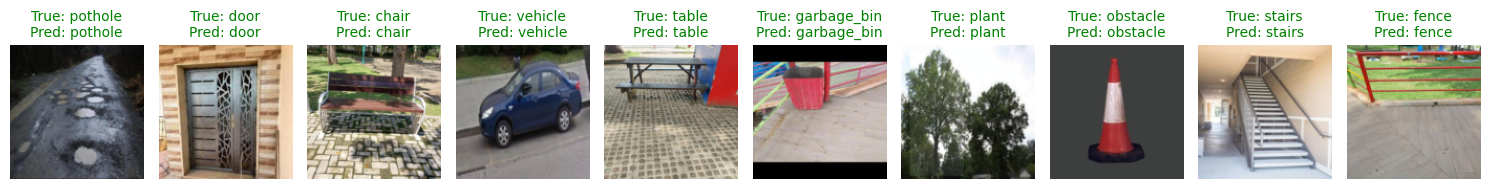

In [8]:
visualize_predictions(mobilenet, val_dataset, num_classes=10, device='cuda')

In [9]:
torch.save(mobilenet.state_dict(), './obstacle_detection_mobilenet1.pth')